<a href="https://colab.research.google.com/github/mohamedyosef101/rl-algorithms/blob/main/Cross%20Entropy/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Cross Entropy Method


---
source: [Deep Reinforcement Learning Hands-On](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition)

---


The core of the cross-entropy method is to throw away bad episodes and train on better ones. So, the steps of the method are as follows:
1. Play N number of episodes using our current model and environment.
2. Calculate the total reward for every episode and decide on a reward boundary. Usually, we use some percentile of all rewards, such as 50th or 70th.
3. Throw away all episodes with a reward below the boundary.
4. Train on the remaining "elite" episodes using observations as the input and issued actions as the desired output.
5. Repeat from step 1 until we become satisfied with the result.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
%%capture
!pip install tensorboardX
!pip install gymnasium

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
from collections import namedtuple
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

# Cross Entropy in CartPole

In [4]:
# set up the environment
env = gym.make('CartPole-v1')

# Action space
print(f"Action sample: \n{env.action_space.sample()}",
      f"\n\nAction space: {env.action_space}")

Action sample: 
1 

Action space: Discrete(2)


The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

0: Push cart to the left

1: Push cart to the right

In [5]:
# Observation Space
print(f"Observation Sample: \n{env.observation_space.sample()}",
      f"\n\nObservation Space: \n{env.observation_space}")

Observation Sample: 
[-3.7622528e+00  1.7857883e+38 -2.8658876e-01 -6.3639275e+37] 

Observation Space: 
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation | Min | Max |
| --- | --- | --- | --- |
| 0 | Cart Position | -4.8 | 4.8 |
| 1 | Cart Velocity | -Inf | Inf |
| 2 | Pole Angle | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3 | Pole Angular Velocity | -Inf | Inf |

In [6]:
class Net(nn.Module):
  def __init__(self, obs_size, hidden_size, n_actions):
    super(Net, self).__init__()
    self.layer1 = nn.Linear(obs_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, n_actions)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    out = self.layer2(x)
    return out

In [7]:
# test the network
testNet = Net(obs_size=4, hidden_size=8, n_actions=2)
inputSample = torch.FloatTensor([env.observation_space.sample()])
testOutput = testNet(inputSample)
print(testOutput)

tensor([[-1.3015e+37,  1.4108e+37]], grad_fn=<AddmmBackward0>)


<ipython-input-7-a0bdb1eaeb7d>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  inputSample = torch.FloatTensor([env.observation_space.sample()])


There is nothing special about our network; it takes a single observation from the environment as an input vector and outputs a number for every action we can perform. The output from the network is a probability distribution over actions, so a straightforward way to proceed would be to include softmax nonlinearity after the last layer. However, in the preceding network we don't apply softmax to increase the numerical stability of the training process.

Rather than calculating softmax (which uses exponentiation) and then calculating cross-entropy loss (which uses logarithm of probabilities), we'll use the PyTorch class, `nn.CrossEntropyLoss`, which combines both softmax and cross-entropy in a single, more numerically stable expression. `CrossEntropyLoss` requires raw, unnormalized values from the network (also called logits), and the downside of this is that we need to remember to apply softmax every time we need to get probabilities from our network's output.

In [8]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

Here we have two helper classes that are named tuples from the collections package in the standard library:
* `EpisodeStep`: This will be used to represent one single step that our agent made in the episode, and it stores the observation from the environment and what action the agent completed. We'll use episode steps from elite episodes as training data.
* `Episode`: This is a single episode stored as total undiscounted reward and a collection of EpisodeStep.

In [9]:
def iterate_batches(env, net, batch_size):
  batch = []
  episode_reward = 0.0
  episode_steps = []
  state, _ = env.reset()
  softmax = nn.Softmax(dim=1)
  while True:
    state_v = torch.FloatTensor([state])
    action_probs = softmax(net(state_v))
    action_probs = action_probs.data.numpy()[0]
    action = np.random.choice(len(action_probs), p=action_probs)
    next_state, reward, terminated, truncated, _ = env.step(action)
    episode_reward += reward
    step = EpisodeStep(observation=state, action=action)
    episode_steps.append(step)
    if terminated or truncated:
      e = Episode(reward=episode_reward, steps=episode_steps)
      batch.append(e)
      episode_reward = 0.0
      episode_steps = []
      next_state, _ = env.reset()
      if len(batch) == batch_size:
        yield batch
        batch = []
    state = next_state

In [10]:
# understand the function

# make the inputs as a tensor
sample_state = torch.FloatTensor([env.observation_space.sample()])
net = Net(obs_size=4, hidden_size=128, n_actions=2)
out = net(sample_state)
print(f"Network output: \n{out} \nwith shape: {out.detach().numpy().shape}",
      "\n=========\n")

# apply softmax function to the output
softmax = nn.Softmax(dim=1)
actions_v = softmax(out)
print(f"Applying softmax to the network output...",
      f"\n output: {actions_v}\n======\n")

# turn it to numpy to make random choice easier
action_probs = actions_v.data.numpy()[0]
print(f"Converting the output to numpy and squeeze the shape...\n",
      f"output: {action_probs}\n========\n")

# choose random action
action = np.random.choice(len(action_probs), p=action_probs)
action_str = "(0) push to left" if action == 0 else "(1) push to right"
print(f"Taking random action...",
      f"\n action: {action_str}\n========\n")

# After that we go on with the loop

Network output: 
tensor([[-4.2728e+37, -6.0388e+37]], grad_fn=<AddmmBackward0>) 
with shape: (1, 2) 

Applying softmax to the network output... 
 output: tensor([[1., 0.]], grad_fn=<SoftmaxBackward0>)

Converting the output to numpy and squeeze the shape...
 output: [1. 0.]

Taking random action... 
 action: (0) push to left



In [11]:
batch_iterator = iterate_batches(env, net, batch_size=16)
test_batch = next(batch_iterator)  # Get the first batch

One very important fact to understand in this function logic is that the training of our network and the generation of our episodes are performed at the same time. They are not completely in parallel, but every time our loop accumulates enough episodes (16), it passes control to this function caller, which is supposed to train the network using the gradient descent. So, when yield is returned, the network will have different, slightly better (we hope) behavior.

In [12]:
def filter_batch(batch, percentile, explain=False):
  rewards = list(map(lambda s: s.reward, batch))
  reward_bound = np.percentile(rewards, percentile)
  reward_mean = float(np.mean(rewards))

  train_states = []
  train_actions = []
  if explain:
    rewards_df = pd.DataFrame({'Value': rewards})
    sns.lineplot(x=range(len(rewards)), y=rewards, color='green')
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.show()
  for reward, steps in batch:
    if reward < reward_bound:
        continue
    train_states.extend(map(lambda step: step.observation, steps))
    train_actions.extend(map(lambda step: step.action, steps))
  if explain:
    print(f"train states before truning to tensors:\n{train_states[0]}")
  train_states = torch.FloatTensor(train_states)
  train_actions = torch.LongTensor(train_actions)
  if explain:
     print(f"train states in one tensor: \n{train_states[0]}")
  return train_states, train_actions, reward_bound, reward_mean

In [13]:
train_states, train_actions, reward_bound, reward_mean = \
 filter_batch(test_batch, percentile=70)
train_states.shape

torch.Size([185, 4])

This function is at the core of the cross-entropy method: from the given batch of episodes and percentile value, it calculates a boundary reward, which is used to filter elite episodes to train on. To obtain the boundary reward, we're using NumPy's percentile function, which from the list of values and the desired percentile, calculates the percentile's value. Then we will calculate mean reward, which is used only for monitoring.

In [14]:
net = Net(4, 128, 2)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)
writer = SummaryWriter(comment="my101-cartpole")

Solved after 26 iterations


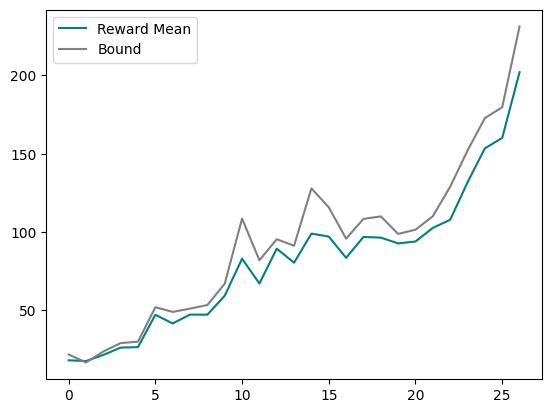

In [15]:
losses = []
reward_bounds = []
reward_means = []
iterations = []
for iter_no, batch in enumerate(iterate_batches(env, net, batch_size=32)):
  states, actions, reward_bound, reward_mean = filter_batch(batch, percentile=70)

  optimizer.zero_grad()  # Clear gradients
  # Correct calculation of log probabilities for cross-entropy loss
  action_scores = net(states)
  loss = objective(action_scores, actions)

  loss.backward()   # Backpropagation
  optimizer.step()   # Update weights

  # results
  iterations.append(iter_no)
  losses.append(loss.item())
  reward_bounds.append(reward_bound)
  reward_means.append(reward_mean)

  if reward_mean > 199:
      print(f"Solved after {iter_no} iterations")
      break

sns.lineplot(x=iterations, y=reward_means, label="Reward Mean", color='teal')
sns.lineplot(x=iterations, y=reward_bounds, label="Bound", color='gray')
plt.show()

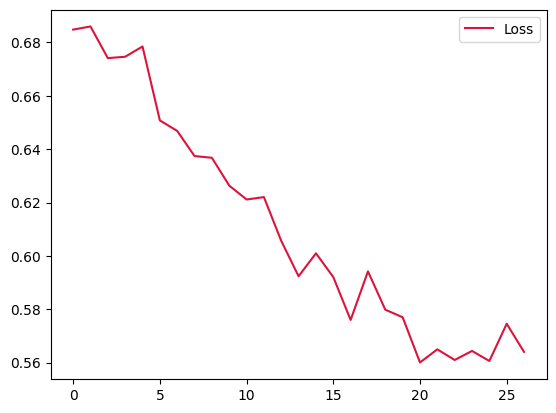

In [16]:
sns.lineplot(x=iterations, y=losses, label="Loss", color='crimson')
plt.show()